# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [17]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False)
        hv = HashingVectorizer(n_features=2 ** 18, alternate_sign=False, ngram_range=(1,1),analyzer='word',stop_words='english')
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [18]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=116)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [19]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_hinge")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12798, 'TN': 114581, 'FP': 137, 'FN': 140, 'Accuracy': 0.9978301059096322, 'Precision': 0.9894085813683804, 'Recall': 0.9891791621579842, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [20]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=.05)
# sklearn.svm.SVC
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12022, 'TN': 114450, 'FP': 268, 'FN': 916, 'Accuracy': 0.9907250736353951, 'Precision': 0.978193653376729, 'Recall': 0.9292008038336682, 'desc': 'svm_train'}


### MODEL: logistic regression

In [21]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12845, 'TN': 114633, 'FP': 85, 'FN': 93, 'Accuracy': 0.9986056276242401, 'Precision': 0.9934261407579273, 'Recall': 0.9928118720049467, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=.05)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12734, 'TN': 103638, 'FP': 11080, 'FN': 204, 'Accuracy': 0.9116061916400325, 'Precision': 0.5347274712354078, 'Recall': 0.9842324934302056, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [23]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12806, 'TN': 114624, 'FP': 94, 'FN': 132, 'Accuracy': 0.9982296170959454, 'Precision': 0.9927131782945736, 'Recall': 0.9897974957489566, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [ ]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=.5)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

### MODEL: Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

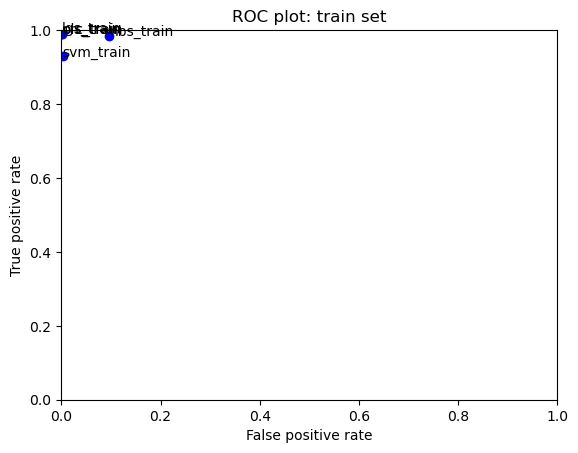

In [24]:
fits = [ols_performance_train,
        svm_performance_train,
        lgs_performance_train,
        nbs_performance_train,
        prc_performance_train,
#         rdg_performance_train, 
#         rdf_performance_train
       ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [25]:
nbs_predictions = nbs.predict(X_train)

In [26]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
431
what you want. I'll fight every wrong genre.
* * * * * * * * * 
1083
Thank you for your message. I am coming.
* * * * * * * * * 
1097
Fine by me. 67.170.215.166
* * * * * * * * * 
1900
then the stuff already put there .
* * * * * * * * * 
1961
"

Well I'm very satisfied because you have finally agreed with me that they have ""Jewish Blood"" instead of being 25% Jewish, So now we will just have to see if you will keep the lies a way from the page because chances are your probaly bipolar so......  "
* * * * * * * * * 
2276
This article is highly innaccurate, and has been written from an ignorant and perverted perspective, on this type of art work from my culture. 220.253.22.120
* * * * * * * * * 
2591
Deathcore band, not Death Metal
* * * * * * * * * 
2678
That I consider as a serious offence. What - watermelon ?
* * * * * * * * * 
2822
"

 A kitten for you! 

Welcome Back =)

  
"
* * * * * * * * * 
2967
Stop trolling 

Stop with the trolling on the hist

17147
Excuse me, but my Cobain edits are fine and I would really appreciate it if you mind your own business.
* * * * * * * * * 
17156
MY OWN PAGE HOWEVER I LIKE IT
* * * * * * * * * 
17501
"
Nonsense.   Imperatrix Mundi "
* * * * * * * * * 
17550
This page has been edited. Republican jacobite (a known UVF sympathizer) should not re-edit this page, as I will keep re-editing it since the edits have been sourced properly.
* * * * * * * * * 
17776
Harassment block? For harassing other users? I've never done that.
* * * * * * * * * 
18114
What are you saying? I added references and theyre located at the bottom of the article. Why are you doing this to people who want to contribute to wiki?
* * * * * * * * * 
18581
NO, Vesa and Projects are two different people, but from same project, the other person is another smart person who is against vandalist by others...
* * * * * * * * * 
18676
'Taurine is also known as bull spunk,aka sperm.'
* * * * * * * * * 
18813
You did not even know what HE w

31864
yeah, i second that
* * * * * * * * * 
31913
I do not recall India declaring war on it's own people, carrying out a genocidal campaign, getting their asses handed to them and losing half of their country. There are a bit of a difference there really.
* * * * * * * * * 
31919
Why are you people disproving facts?
* * * * * * * * * 
32107
"

 Please do not vandalize pages, as you did with this edit to User talk:Wysprgr2005. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
32758
Peking Duck is a chinese- style food dish.  98.25.30.188
* * * * * * * * * 
32795
If someone does end up putting that sock stuff again, tell them it's your page and they have no right to post things you don't want on your page.

 Stack the Deck 
I heard this new game is coming out, do you have any details?
* * * * * * * * * 
33153
(but somehow non-Nazi, non-fascist affiliations of great-grandfather do)
* * * * * * * * * 
33361
REDIRECT User talk:Dream out loud/Archive 7
* * 

46418
Talkback 

108.85.24.203
* * * * * * * * * 
46538
Yeah, whatever, if that makes you sleep better.
* * * * * * * * * 
46559
Apparently the write did not get permission from Miss Greenwald to post this material in the article and has requested the appropriate removal.  If you have any questions, email her.
* * * * * * * * * 
46647
I am glad that wikipedia has realized the malicious intent of the wikicohen account. 70.26.72.221
* * * * * * * * * 
46867
(Note by brab) I've uploaded it on ImageShack
* * * * * * * * * 
46892
thank you for unblocking me. in case Leki checks this, i apologize for my addition to your talk page
* * * * * * * * * 
47105
"

He sends warnings so fast because ""he"" is a bot that is sanctioned by wikipedia to protect pages of people who PAY MONEY to him.  that's how wikipedia makes all of its money, outside of donations.  by paying protection money to this user."
* * * * * * * * * 
47668
"
I would like to agree with you, and maybe I do have a slight bias again

61097
who is doing this. im mark
* * * * * * * * * 
61625
I added a source for my claim, while you constantly revert my edits threating me you will report me. We can't discuss that way.
* * * * * * * * * 
61646
Sorry, I do not respond to trolls.
* * * * * * * * * 
61856
Just because a fascist doesn't like doesn't mean they are self-promoting, they were two scientific views of the problem one, by Bulgarian and one by Greek, I didn't write any of them!
* * * * * * * * * 
61879
Hey
How do I fill up my page with silly boxes? Those are awesome.
* * * * * * * * * 
62171
Yo dawg 

I love a nice pair of big breasts as the next guy, but you just can't put that in random articles. 66.68.86.111
* * * * * * * * * 
62256
, followed by user:Makecat so they have aids in China! Grats!! Now the black supremacist User:Malik Shabazz wants to get in on it. Well, monkeys and all
* * * * * * * * * 
62282
Support- stops the POV of nationalist editors
* * * * * * * * * 
62327
Your pretty special you know love

76354
":What do you mean? Where have I erred in judgment? When I said you were disruptive at the article or when I said you resorted to personal attacks? 1 != 2 

"
* * * * * * * * * 
76451
It's aganist any logic to try to separate the end of the monarchy from the end of the institution of the King. Monarchy, and with that Kingdom, existed until 29 November 1945. I hope you understand now.

Military Prime Ministers must be marked with darkkhaki color, not with white color like non-party politicians.

Oficial name of the country must be written above the list of Prime Ministers of that country. 

I appeal to you to stop with this nonsense already.
* * * * * * * * * 
76550
Hmm, I still don't see why you like to delete things instead of help improve them. Not everything I said about NU Metal was opinion based. Next time, instead of reversing edits and deleting contributions by people, maybe you should contribute as well. That's how everything great ever came into existance. 75.139.103.133

stop it
* * * * * * * * * 
91231
HEY why are you deleting my apology?? do you have to right to do that? I think you do but why delete it?? isn't this my talk page? and high kick is my page i made don't delete photos off it!! and i can delete the clean up stuff! If you delete this message too!! Don't please!
* * * * * * * * * 
91340
Meow meow boom boom now now
* * * * * * * * * 
91501
The article is NOT about the afterlife. The afterlife includes several parts: life in the grave, the day of judgement and then life in paradise or hell. This article is only a survey of the Muslim narrative of the Day of Judgement, not an article about the afterlife in general.
* * * * * * * * * 
91568
"
I used to post under ""Marsden."" Does that help?  "
* * * * * * * * * 
91923
guess what 

your retarded
* * * * * * * * * 
92308
( I did not log in yet, so do not get upset.)
* * * * * * * * * 
92345
rock alternative????? what is your problem????!!!! 

alternative rock??????????(like a placebo,radiohead,3

105293
Just stop it now...thanks.
* * * * * * * * * 
105491
This is a dynamic IP used by many owned by few
* * * * * * * * * 
105751
Ahh ok. that makes sence now.  |  trácht ar
* * * * * * * * * 
105824
btw, what's a sock puppet?
* * * * * * * * * 
105840
Cutthroat trout PR 
I'm almost done there and don't have anything else to add. I suspect the article is near FA quality. I'll run through it once again tomorrow.
* * * * * * * * * 
106190
live in India. I live in a Hindu majority country.
* * * * * * * * * 
106382
"
Hey, acknowledging that we are all biased is the first step! Though if I see your alter ego on the main page again, I'll know where to complain... ;-) propaganda "
* * * * * * * * * 
107407
- The reference to this activity by user 92.11.47.205 is at Aaron
* * * * * * * * * 
107433
NO I HATE IT BECAUSE YOU DELETE EVERYTHING
* * * * * * * * * 
107607
I tried to get some more of that in the article, there is really a lot of coverage out there about this. I had a hard time fin

IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME OF YTMND!IN THE NAME O

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [27]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 2025, 'TN': 27184, 'FP': 1444, 'FN': 1262, 'Accuracy': 0.9152122826257246, 'Precision': 0.5837417123090227, 'Recall': 0.6160632795862488, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [28]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 2107, 'TN': 27774, 'FP': 854, 'FN': 1180, 'Accuracy': 0.9362682124392918, 'Precision': 0.7115839243498818, 'Recall': 0.6410100395497415, 'desc': 'svm_test'}


### MODEL: logistic regression

In [29]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 1979, 'TN': 27262, 'FP': 1366, 'FN': 1308, 'Accuracy': 0.9162149459501802, 'Precision': 0.5916292974588939, 'Recall': 0.6020687557042896, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [30]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 2093, 'TN': 23310, 'FP': 5318, 'FN': 1194, 'Accuracy': 0.7959580134732884, 'Precision': 0.28241802725678045, 'Recall': 0.6367508366291451, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [31]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 1979, 'TN': 27311, 'FP': 1317, 'FN': 1308, 'Accuracy': 0.9177502741657528, 'Precision': 0.6004247572815534, 'Recall': 0.6020687557042896, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [23]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 1888, 'TN': 26729, 'FP': 1899, 'FN': 1399, 'Accuracy': 0.8966630111232963, 'Precision': 0.49854766305782944, 'Recall': 0.5743839367204138, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [24]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 0, 'TN': 28628, 'FP': 0, 'FN': 3287, 'Accuracy': 0.8970076766410778, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


/Users/tatianakalainoff/Documents/GitHub/machine-learning/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

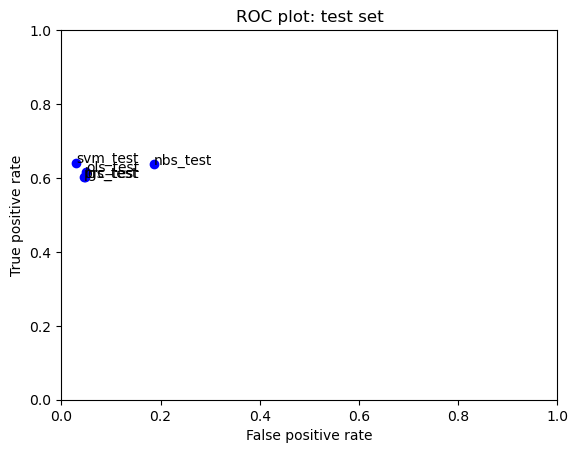

In [32]:
fits = [ols_performance_test,
        svm_performance_test,
        lgs_performance_test,
        nbs_performance_test,
        prc_performance_test,
#         rdg_performance_test,
#         rdf_performance_test
       ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [33]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_test.csv', my_random_seed=116, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 262144)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [34]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.20775769763129717


In [35]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [36]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [37]:
my_submission.shape

(153164, 2)

In [38]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./data/toxiccomments_submission_3.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation